### requirements
- python 3.9.12 +
- conda 4.12.10 +

no additional libraries need to be installed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split

#### init

in case the master file is located elsewhere, please change 'file_path' accordingly

In [2]:
#reading master data

file_path = "Baza_Quant_O2.dsv"
df  = pd.read_csv(file_path, delimiter="|")

#### Calculation of the Observable Default Rate

The code first converts the 'OBSERVATION_DATE' column to a datetime object using the pd.to_datetime function.

Then it sorts the dataframe by 'CLIENT_ID' and 'OBSERVATION_DATE' in ascending order. This is done to ensure that the data for each client is ordered chronologically.

In the next step, a new column 'NEXT_12_MONTHS_DEFAULT' is created. This column is a shifted version of the 'DEFAULT_FLAG' column, moved 12 steps backwards (hence -12). This way, for each client and at each observation date, we can see if there will be a default in the next 12 months. This is accomplished by using groupby to group the data by 'CLIENT_ID', and then applying the shift function to the 'DEFAULT_FLAG' column.

After creating the 'NEXT_12_MONTHS_DEFAULT' column, the code then calculates the total number of clients and the number of defaulted clients at each date. The total number of clients is computed by grouping the data by 'OBSERVATION_DATE' and then counting the number of 'CLIENT_ID's. The number of defaulted clients is computed in a similar way, but here it only considers the rows where 'NEXT_12_MONTHS_DEFAULT' is equal to 1 (i.e., a default will occur in the next 12 months).

Once the total number of clients and the number of defaulted clients have been computed, the default rate (dr) can be calculated. The default rate is the number of defaulted clients divided by the total number of clients. This calculation is done for each observation date. The fillna(0) method is used to replace any NaN values with zero, which could occur if the total number of clients is zero at any date.

>Correctness of the observed default rate calculation

>In order to build such a model a bank usually calculates the observed PD or the so-called observed default rate (DR). The outcome of the DR is 12 months, this is equivalent to a PD for the next 12 months.

In [3]:
#calculating dependent variable

# Converting OBSERVATION_DATE to datetime
df['OBSERVATION_DATE'] = pd.to_datetime(df['OBSERVATION_DATE'])

# First, sort data by client and date
df.sort_values(by=['CLIENT_ID', 'OBSERVATION_DATE'], inplace=True)

# Create a shifted version of DEFAULT_FLAG column to identify defaults in the next 12 months
df['NEXT_12_MONTHS_DEFAULT'] = df.groupby('CLIENT_ID')['DEFAULT_FLAG'].shift(-12)

# Calculate total clients and defaulted clients at each date
total_clients = df.groupby('OBSERVATION_DATE')['CLIENT_ID'].count()
defaulted_clients = df[df['NEXT_12_MONTHS_DEFAULT'] == 1].groupby('OBSERVATION_DATE')['CLIENT_ID'].count()

# Calculate observed default rate
dr = (defaulted_clients / total_clients).fillna(0)

# Renaming columns
dr = dr.reset_index()
dr.columns = ['date', 'default_rate']
dr.to_csv("Default Rate", index=False)

dr.head()

,date,default_rate
0,2008-01-31,0.019310
1,2008-02-29,0.019860
2,2008-03-31,0.021054
3,2008-04-30,0.021991
4,2008-05-31,0.023064


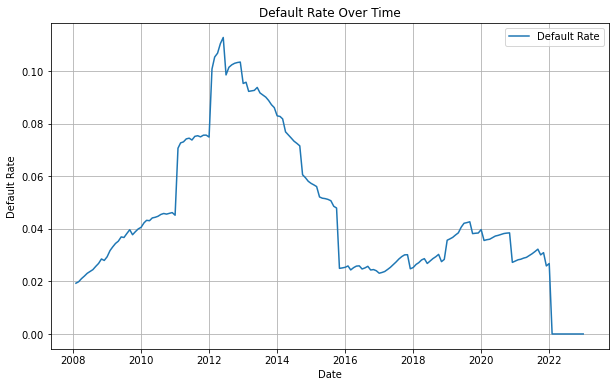

In [4]:
#plotting the DR

plt.figure(figsize=(10,6))
plt.plot(dr['date'], dr['default_rate'], label='Default Rate')
plt.xlabel('Date')
plt.ylabel('Default Rate')
plt.title('Default Rate Over Time')
plt.legend()  # show legend
plt.grid(True)  # show gridlines
plt.show()  # display the plot

In [5]:
# Converting to datetime
dr['date'] = pd.to_datetime(dr['date'])

# Setting the date records as 1st of each month to be easier to join
dr['date'] = dr['date'].dt.to_period('M').dt.to_timestamp()


#2022 is irrelevant for the analysis since it doesn't have records, as they have to be followed bu 10 months for the rate to be calculated
dr = dr[dr['date'].dt.year != 2022]

print(dr.head())

        date  default_rate
0 2008-01-01      0.019310
1 2008-02-01      0.019860
2 2008-03-01      0.021054
3 2008-04-01      0.021991
4 2008-05-01      0.023064


In [6]:
# Function for converting BNR date records to the desirired format

def convert_romanian_date(date):
    month_mapping = {
        'ian.': 'Jan',
        'feb.': 'Feb',
        'mar.': 'Mar',
        'apr.': 'Apr',
        'mai.': 'May',
        'iun.': 'Jun',
        'iul.': 'Jul',
        'aug.': 'Aug',
        'sep.': 'Sep',
        'oct.': 'Oct',
        'nov.': 'Nov',
        'dec.': 'Dec',
    }
    
    for romanian, english in month_mapping.items():
        date = date.replace(romanian, english + '.')
    
    return datetime.strptime(date, '%b. %Y')

In [7]:
# Function that returns the correlation matrix of a DF in comparison with the DR

def calculate_default_rate_correlation(data_frame):
    # Assuming 'dr' is the 'default_rate' DataFrame and 'average_wage' is the DataFrame to be merged
    merged_df = pd.merge(dr, data_frame, on='date', how='inner')
    correlation_matrix = merged_df.corr()['default_rate']
    return correlation_matrix

In [8]:
# Reading exchange rates data
exchange_rates = pd.read_csv("BNR_ExchRate.csv", delimiter=';')

# Converting to date
exchange_rates['Data'] = exchange_rates['Data'].apply(convert_romanian_date)

# Changing the decimal delimiter
exchange_rates.replace(',', '.', regex=True, inplace=True)

# Replacing missing value indicator with NAs, then dropping them
exchange_rates.replace('-', pd.NA, inplace=True)
exchange_rates.dropna(axis=1, inplace=True)

# Converting object types in df to floats
for column in exchange_rates.columns:
    if exchange_rates[column].dtype == 'object':
        exchange_rates[column] = exchange_rates[column].astype(float)


In [9]:
# Selecting and renaming the desired columns
exchange_rates = exchange_rates[['Data', 'EUR  mediu (RON/EUR) CURSL_EURM', 'GBP  mediu (RON/GBP) CURSL_GBPM', 'USD  mediu (RON/USD) CURSL_USDM', 'MDL  mediu (RON/MDL) CURSL_MDLM', 'HUF  mediu (RON/HUF) CURSL_HUFM']]
exchange_rates.rename(columns={'Data': 'date', 'EUR  mediu (RON/EUR) CURSL_EURM': 'RON/EUR', 'GBP  mediu (RON/GBP) CURSL_GBPM': 'RON/GBP', 'USD  mediu (RON/USD) CURSL_USDM': 'RON/USD', 'MDL  mediu (RON/MDL) CURSL_MDLM': 'RON/MDL', 'HUF  mediu (RON/HUF) CURSL_HUFM': 'RON/HUF'}, inplace=True)

# Adding lagged (t-1) values to check if they correlate any better
exchange_rates['RON/EUR_t-1'] = exchange_rates['RON/EUR'].shift(1)
exchange_rates['RON/GBP_t-1'] = exchange_rates['RON/GBP'].shift(1)
exchange_rates['RON/USD_t-1'] = exchange_rates['RON/USD'].shift(1)
exchange_rates['RON/MDL_t-1'] = exchange_rates['RON/MDL'].shift(1)
exchange_rates['RON/HUF_t-1'] = exchange_rates['RON/HUF'].shift(1)

In [10]:
# Printing Correlations

print(calculate_default_rate_correlation(exchange_rates))

default_rate    1.000000
RON/EUR        -0.081194
RON/GBP         0.047819
RON/USD        -0.304942
RON/MDL         0.589984
RON/HUF         0.417265
RON/EUR_t-1    -0.090130
RON/GBP_t-1     0.069518
RON/USD_t-1    -0.309629
RON/MDL_t-1     0.559947
RON/HUF_t-1     0.402118
Name: default_rate, dtype: float64


In [11]:
# Importing average wage, cleaning and adding lagged (t-1) values

average_wage = pd.read_csv("INS_AverageWage.csv", delimiter=',')
average_wage['Luna'] = pd.to_datetime(average_wage['Luna'])

average_wage = average_wage.rename(columns={'Luna': 'date', 'Salariu': 'net_wage'})
average_wage['net_wage_t-1'] = average_wage['net_wage'].shift(1)

In [12]:
# Correlation
print(print(calculate_default_rate_correlation(average_wage)))

default_rate    1.000000
net_wage       -0.432320
net_wage_t-1   -0.437782
Name: default_rate, dtype: float64
None


In [13]:
# Importing industrial production indexes, and selecting the total
industrial_index = pd.read_csv("industrial_index.csv", delimiter=',')
industrial_index['Date'] = pd.to_datetime(industrial_index['Date'])

industrial_index = industrial_index[['Date', 'INDUSTRY – TOTAL']]
industrial_index.rename(columns={'Date': 'date', 'INDUSTRY – TOTAL': 'ind_index'}, inplace=True)

In [14]:
# Correlation
print(print(calculate_default_rate_correlation(industrial_index)))

default_rate    1.000000
ind_index      -0.577828
Name: default_rate, dtype: float64
None


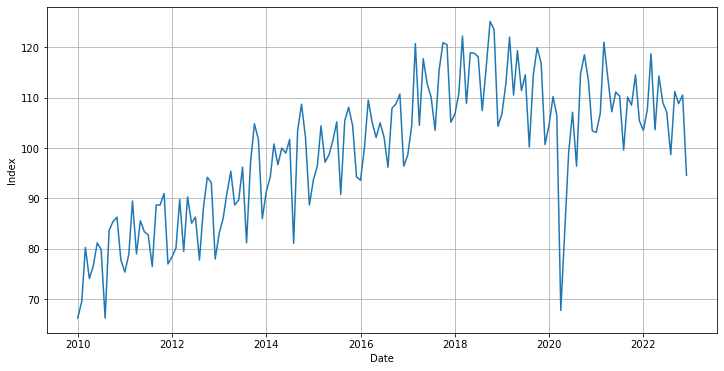

In [15]:
# Checking if this index has seasonal behaviour using a plot

plt.figure(figsize=(12, 6))
plt.plot(industrial_index['date'], industrial_index['ind_index'])
plt.xlabel('Date')
plt.ylabel('Index')
plt.grid(True)
plt.show()

In [16]:
#removing sesonality and checking correlation for the desizonalized one and laged desizonalized (t-1)
decomposition = seasonal_decompose(industrial_index['ind_index'], model='additive', period=12)

industrial_index_adjusted = pd.DataFrame({'date': industrial_index['date'], 'seasonally_adjusted': (industrial_index['ind_index'] - decomposition.seasonal)})
industrial_index_adjusted['seasonally_adjusted_t-1'] = industrial_index_adjusted['seasonally_adjusted'].shift(1)

print(print(calculate_default_rate_correlation(industrial_index_adjusted)))

default_rate               1.000000
seasonally_adjusted       -0.625265
seasonally_adjusted_t-1   -0.634022
Name: default_rate, dtype: float64
None


#### first model - AR

>Potential models: linear regression, autoregressive (AR), autoregressive moving average (ARMA), autoregressive with distributed lags (ARDL), models to address seasonality endogenously (e.g. SARIMAX), random forest, neural networks, RNN, LSTM, etc.


> Relevant value for R square, > 40%


>Assess model performance through specific validation tests: p-values, R-squared, relevant business sign of macro drivers

In [17]:

ar_dr = dr.copy()

# Create lagged versions of the 'default_rate' column
ar_dr['default_rate_lag1'] = ar_dr['default_rate'].shift(1)
ar_dr['default_rate_lag2'] = ar_dr['default_rate'].shift(2)

# Remove missing values introduced by the lagged transformation
ar_dr.dropna(inplace=True)

# Split the data into training and testing sets
train_ratio = 0.8
train_size = int(len(ar_dr) * train_ratio)
train_data = ar_dr[:train_size]
test_data = ar_dr[train_size:]

# Select the target variable and independent variables for training
train_target = train_data['default_rate']
train_independent_vars = train_data[['default_rate_lag1', 'default_rate_lag2']]

# Add a constant term for the intercept
train_independent_vars = sm.add_constant(train_independent_vars)

# Fit the autoregressive model on the training data
model = sm.OLS(train_target, train_independent_vars)
fitted_ar_model = model.fit()

print(fitted_ar_model.summary())

                            OLS Regression Results                            
Dep. Variable:           default_rate   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2451.
Date:                Tue, 30 May 2023   Prob (F-statistic):          2.39e-103
Time:                        22:51:27   Log-Likelihood:                 530.37
No. Observations:                 132   AIC:                            -1055.
Df Residuals:                     129   BIC:                            -1046.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.00

#### tests

> Validation tests outcome

>best linear unbiased estimator BLUE tests (no collinearity, stationarity of drivers,
homoscedasticity, no autocorrelation, normality of errors, linear functional form)

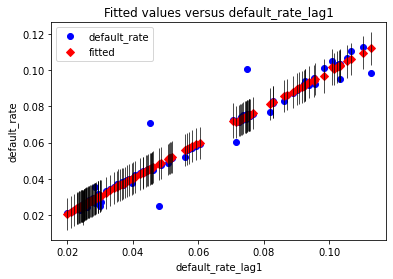

In [18]:
# Checking the distribution of residuals
sm.graphics.plot_fit(fitted_ar_model, 1)
plt.show()

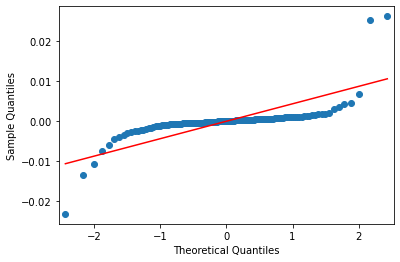

In [19]:
# Checking the normal distribution of residuals using a Q-Q plot
sm.qqplot(fitted_ar_model.resid, line='s')
plt.show()

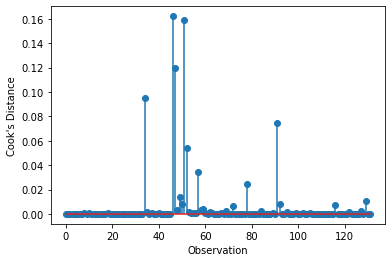

In [20]:
# Checking the influence of each observation on the model coefficients
influence = fitted_ar_model.get_influence()
cooks_distance = influence.cooks_distance[0]
plt.stem(cooks_distance)
plt.xlabel('Observation')
plt.ylabel('Cook\'s Distance')
plt.show()

In [21]:
# Checking the normal distribution of residuals using the Shapiro-Wilk test
shapiro_test = shapiro(fitted_ar_model.resid)
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

Shapiro-Wilk Test p-value: 9.118788407972058e-19


In [22]:
# Checking for homoscedasticity of residuals using the Breusch-Pagan test
bp_test = sm.stats.diagnostic.het_breuschpagan(fitted_ar_model.resid, fitted_ar_model.model.exog)
print("Breusch-Pagan Test p-value:", bp_test[1])

Breusch-Pagan Test p-value: 0.6046950150606116


In [23]:
# Checking for autocorrelation of residuals using the Durbin-Watson test
dw_test = sm.stats.stattools.durbin_watson(fitted_ar_model.resid)
print("Durbin-Watson Test statistic:", dw_test)

Durbin-Watson Test statistic: 2.0076188286548837


#### forecast testing

> Correctness of the forecasts calculated with the model

Mean Squared Error (MSE): 6.599984793110347e-06


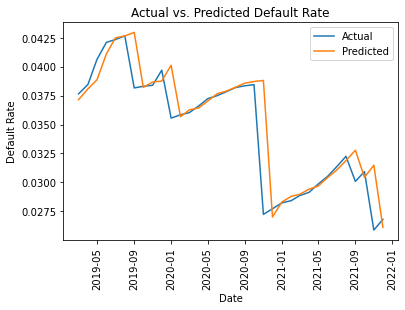

In [24]:
# Perform prediction on the testing data
test_target = test_data['default_rate']
test_independent_vars = test_data[['default_rate_lag1', 'default_rate_lag2']]
test_independent_vars = sm.add_constant(test_independent_vars)
predictions = fitted_ar_model.predict(test_independent_vars)

# Evaluate the model performance on the testing data (e.g., calculate metrics or plot results)
mse = mean_squared_error(test_target, predictions)
print("Mean Squared Error (MSE):", mse)

# Plot the actual vs. predicted values
plt.plot(test_data['date'], test_target, label='Actual')
plt.plot(test_data['date'], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Default Rate')
plt.title('Actual vs. Predicted Default Rate')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

#### second model

> conduct scenario analysis to study the effect of shocks on predicted default rates, determine an appropriate size of the shock and provide economic interpretations
> usage of transformed risk drivers (e.g. LAGs, differences, logs, etc. and determining their optimal combination in the model)
> obtaining at least a 70% R-squared or equivalent with all validation tests accounted for on linear regression
> model with more than 2 relevant macroeconomic drivers
> generate a second “alternative” model using a different modeling technique (e.g. if the main model is a linear regression, an alternative model can be AR)
> 10%: Effect of shocks
> 5%: Alternative mode
> 10%: More than 2 independent risk drivers
> 10%: Getting very good R2 and validation outcome on linear regression
> 10%: Usage of transformed independent risk drivers

In [25]:

merged_df = pd.merge(dr[['date', 'default_rate']],
                     industrial_index_adjusted[['date', 'seasonally_adjusted_t-1']],
                     on='date',
                     how='inner')

merged_df = pd.merge(merged_df,
                     average_wage[['date', 'net_wage_t-1']],
                     on='date',
                     how='inner')

merged_df = pd.merge(merged_df,
                     exchange_rates[['date', 'RON/MDL_t-1']],
                     on='date',
                     how='inner')

# Assign the dependent variable and independent variables
y = merged_df['default_rate']
X = merged_df[['seasonally_adjusted_t-1', 'net_wage_t-1', 'RON/MDL_t-1']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remove rows with missing values from the training set
train_data = pd.concat([y_train, X_train], axis=1).dropna()
y_train = train_data['default_rate']
X_train = train_data[['seasonally_adjusted_t-1', 'net_wage_t-1', 'RON/MDL_t-1']]

# Add a constant term for the intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the multiple linear regression model
model = sm.OLS(y_train, X_train)
fitted_lr_model = model.fit()

# Print the model summary
print(fitted_lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:           default_rate   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     111.2
Date:                Tue, 30 May 2023   Prob (F-statistic):           3.56e-33
Time:                        22:51:28   Log-Likelihood:                 330.40
No. Observations:                 114   AIC:                            -652.8
Df Residuals:                     110   BIC:                            -641.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### tests

> Validation tests outcome

>best linear unbiased estimator BLUE tests (no collinearity, stationarity of drivers,
homoscedasticity, no autocorrelation, normality of errors, linear functional form)

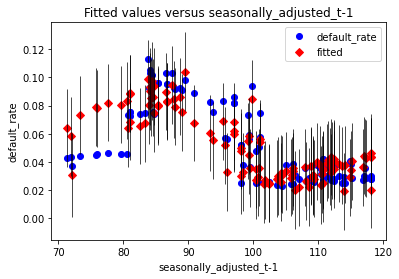

In [26]:
# Checking the distribution of residuals
sm.graphics.plot_fit(fitted_lr_model, 1)
plt.show()

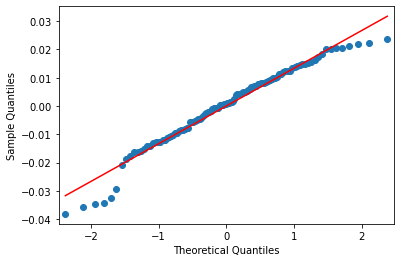

In [27]:
# Checking the normal distribution of residuals using a Q-Q plot
sm.qqplot(fitted_lr_model.resid, line='s')
plt.show()

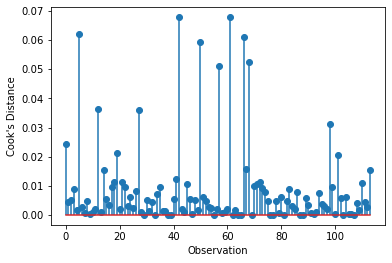

In [28]:
# Checking the influence of each observation on the model coefficients
influence = fitted_lr_model.get_influence()
cooks_distance = influence.cooks_distance[0]
plt.stem(cooks_distance)
plt.xlabel('Observation')
plt.ylabel('Cook\'s Distance')
plt.show()

In [29]:
# Checking the normal distribution of residuals using the Shapiro-Wilk test
shapiro_test = shapiro(fitted_lr_model.resid)
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

Shapiro-Wilk Test p-value: 0.004095206968486309


In [30]:
# Checking for homoscedasticity of residuals using the Breusch-Pagan test
bp_test = sm.stats.diagnostic.het_breuschpagan(fitted_lr_model.resid, fitted_lr_model.model.exog)
print("Breusch-Pagan Test p-value:", bp_test[1])

Breusch-Pagan Test p-value: 1.699565626951624e-05


In [31]:
# Checking for autocorrelation of residuals using the Durbin-Watson test
dw_test = sm.stats.stattools.durbin_watson(fitted_lr_model.resid)
print("Durbin-Watson Test statistic:", dw_test)

Durbin-Watson Test statistic: 2.210042461735009


#### forecast testing

> Correctness of the forecasts calculated with the model

Mean Squared Error (MSE): 0.00021526679432458347


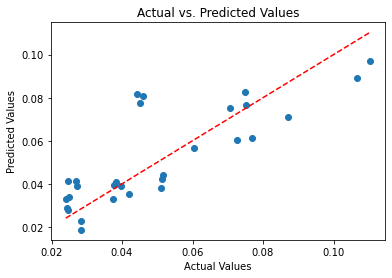

In [32]:
# Perform predictions on the testing data
y_pred = fitted_lr_model.predict(X_test)

# Evaluate the model performance
mse = np.mean((y_pred - y_test) ** 2)
print("Mean Squared Error (MSE):", mse)

# Plot actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()